In [8]:
# 3.6.1 Boston Housing データセット

# リスト 3-24: Boston Housing データセットの読み込み
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [19]:
# 3.6.2 データの準備
import numpy as np

# リスト 3-25: データの正規化
# データセットにあるデータの値は異なる範囲を取っている
# そのままニューラルネットワークに与えると問題なので正規化する
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# 正規化の結果「中心がゼロになる」と書いてあるが、中央値はゼロにならない
# ちなみに平均も綺麗な値になっていない
# np.median(train_data[0]), np.median(test_data[0])
# np.mean(train_data[0]), np.mean(test_data[0])

(0.026154884944008285, 70.12556153846154)

In [41]:
# 3.6.3 ニューラルネットワークの構築

# リスト 3-26: モデルの定義
from keras import models
from keras import layers

def build_model():
    # 同じモデルを複数回インスタンス化する必要があるため
    # モデルをインスタンス化するための関数を使用
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    # 出力層では活性化関数を使わない
    # 活性化関数は出力値を 0~1 などに正規化するなどの働きをするので、スカラ値の場合は必要ない、というかやってはいけない
    model.add(layers.Dense(1))
    # 損失関数にMSE(平均二乗誤差)、指標にMAE(平均絶対誤差)を用いている
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [45]:
# リスト 3-27: k分割交差検証
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    
    # 検証データの準備: フォールドiのデータ
    val_data = \
        train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = \
        train_targets[i * num_val_samples: (i+1) * num_val_samples]
    # print(np.mean(val_data))
    
    # 訓練データの準備: 残りのフォールドのデータ
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples:],
         train_targets[(i+1) * num_val_samples:]],
        axis=0)
    
    # Kerasモデルを構築（コンパイル済み）
    model = build_model()
    
    # モデルをサイレントモード(verbose=0)で適合
    model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0)
    
    # モデルを検証データで評価
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [55]:
np.mean(all_scores), all_scores

# リスト 3-28: フォールドごとに検証ログを保存
num_epochs = 500
all_mae_histories = []
for i in range(k):
    # 検証データの準備: フォールドiのデータ
    print('processing fold #', i)
    val_data = \
        train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = \
        train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # 訓練データの準備: 残りのフォールドのデータ
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0)
    
    # Kerasモデルを構築
    model = build_model()
    
    # モデルをサイレントモード(verbose=0)で実行
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


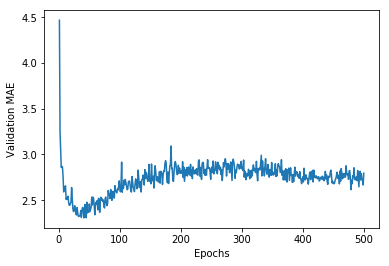

In [69]:
# リスト 3-29: k分割交差検証の平均スコアの履歴を構築
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

# リスト 3-30: 検証スコアのプロット
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

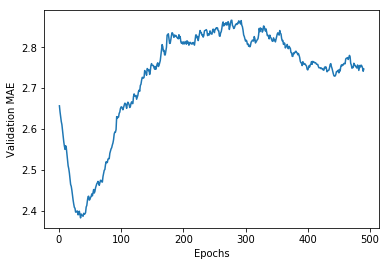

In [70]:
# リスト 3-31: 最初の10個のデータ点を除外した検証スコアのプロット
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            # 指数移動平均に置き換えることで、曲線を滑らかにする
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 10個目までのデータを捨て、それ以降のデータは移動平均で滑らかにする
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [73]:
# 前回のプロットからわかったのは、検証スコアが80エポックあたりが最も大きく改善されている
# それ以降は過学習に陥っているということ
# エポック数を調整して、最終的なモデルを作り直す

# リスト 3-32: 最終的なモデルの訓練
# コンパイル済みの新しいモデルを取得
model = build_model()

# データ全体を使って訓練
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
# ↑ validation=(val_data, val_targets) はなぜ入らないのか？

# テストデータでの検証スコアを取得
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [74]:
test_mse_score, test_mae_score

(5000265.725490196, 2157.5708151424633)